In [1]:
from glob import glob
import pandas as pd

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from kid_readout.analysis import resonator, plot_resonator

from notebooks.library import display
display.hide_code()

In [2]:
def load_s2p_re_im(filename):
    f_GHz, S11RE, S11IM, S21RE, S21IM, S12RE, S12IM, S22RE, S22IM = np.loadtxt(filename, unpack=True, skiprows=23)
    
    df = pd.DataFrame.from_dict({'f': 1e9 * f_GHz,
                                 's11': S11RE + 1j * S11IM,
                                 's21': S21RE + 1j * S21IM,
                                 's12': S12RE + 1j * S12IM,
                                 's22': S22RE + 1j * S22IM})
    return df


def fit_resonators(dfs, offset=0.4e-3):
    rs = []
    for df in dfs:
        f_center = df.f.mean()
        mask = np.array((f_center * (1 - offset) < df.f) & (df.f < f_center * (1 + offset)))
        rs.append(resonator.Resonator(np.array(df.f), np.array(df.s21), mask=mask))
    return rs

In [3]:
mag_up_color = 'blue'
mag_none_color = 'green'
mag_down_color = 'orange'
mag_down2_color = 'red'

In [4]:
directory = '/Users/daniel/Johnson+Miller/mkid/dual-pol/jpl/cooldown_2016-02-05/'

In [5]:
# Magnet creating upward field to cancel ambient
# 3606 MHz looks fine but doesn't fit
mag_up_good_files = [f for f in glob(directory + '2016-02-08_up_????_MHz.s2p')
                     if not '3606' in f]
mag_up = [load_s2p_re_im(f) for f in mag_up_good_files]
mag_up_wide = [load_s2p_re_im(directory + f) for f in
               ('2016-02-08_up_1263_MHz_four.s2p',
                '2016-02-08_up_1300-1350_MHz.s2p',
                '2016-02-08_up_1350-1400_MHz.s2p',
                '2016-02-08_up_1800-1850_MHz.s2p',
                '2016-02-08_up_1850-1900_MHz.s2p',
                '2016-02-08_up_1900-1950_MHz.s2p',
                '2016-02-08_up_1950-2000_MHz.s2p',
                '2016-02-08_up_2050-2100_MHz.s2p',
                '2016-02-08_up_2450-2500_MHz.s2p',
                '2016-02-08_up_2750-2800_MHz.s2p')]

# No magnet
mag_none_good_files = [f for f in glob(directory + '2016-02-09_none_????_MHz.s2p')]
mag_none = [load_s2p_re_im(f) for f in mag_none_good_files]

# Magnet creating downward field to augment ambient field
mag_down_good_files = [f for f in glob(directory + '2016-02-09_down_????_MHz.s2p')]
mag_down = [load_s2p_re_im(f) for f in mag_down_good_files]

# Two magnets creating downward field to augment ambient field
mag_down2_good_files = [f for f in glob(directory + '2016-02-10_down2_????_MHz.s2p')
                        if not '1237' in f]
mag_down2 = [load_s2p_re_im(f) for f in mag_down2_good_files]

In [16]:
mag_down2_bad = load_s2p_re_im(directory + '2016-02-10_down2_1237_MHz.s2p')

In [23]:
r_mag_down2_bad = fit_resonators([mag_down2_bad], offset=0.28e-3)

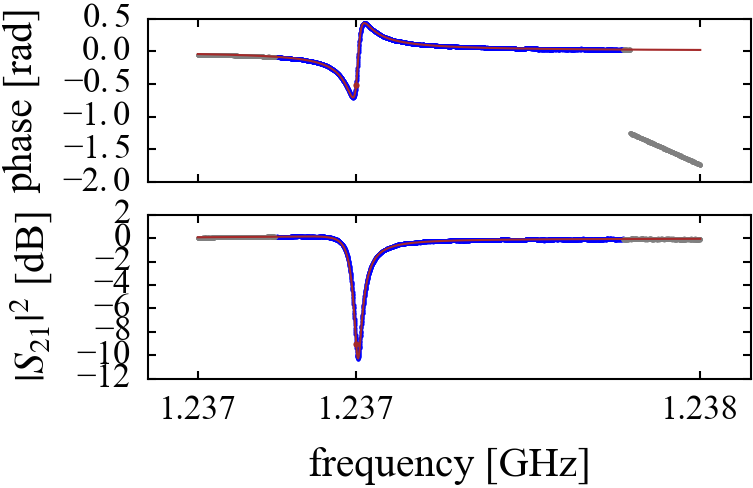

In [24]:
plot_resonator.amplitude_and_phase(r_mag_down2_bad[0], normalize_s21=True, freq_scale=1e-9, xlabel='frequency [GHz]');

In [36]:
rs_mag_up = fit_resonators(mag_up)
rs_mag_none = fit_resonators(mag_none)
rs_mag_down = fit_resonators(mag_down)
rs_mag_down2 = fit_resonators(mag_down2)

In [37]:
rs_mag_down2.insert(0, r_mag_down2_bad[0])

# All data

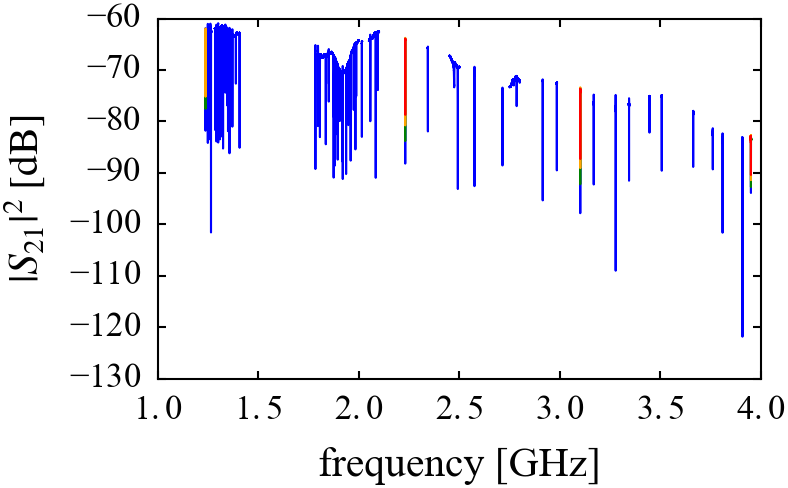

In [38]:
fig, ax = plt.subplots()

for df in mag_up + mag_up_wide:
    ax.plot(1e-9 * df.f,
            20 * np.log10(np.abs(df.s21)),
            color=mag_up_color)

for df in mag_none:
    ax.plot(1e-9 * df.f,
            20 * np.log10(np.abs(df.s21)),
            color=mag_none_color)

for df in mag_down:
    ax.plot(1e-9 * df.f,
            20 * np.log10(np.abs(df.s21)),
            color=mag_down_color)

for df in mag_down2:
    ax.plot(1e-9 * df.f,
            20 * np.log10(np.abs(df.s21)),
            color=mag_down2_color)
    
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel(r'$|S_{21}|^2 \; [\mathrm{dB}]$');

# Quality factors: magnet up

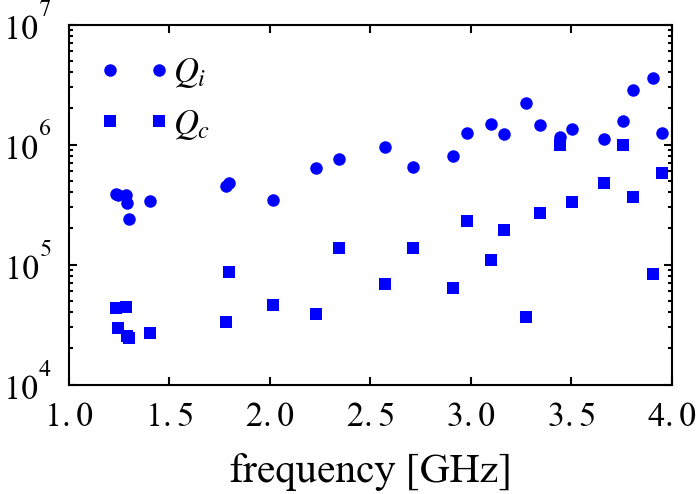

In [39]:
fig, ax = plt.subplots()

ax.plot([1e-9 * r.f_0 for r in rs_mag_up],
        [r.Q_i for r in rs_mag_up],
        marker='o', markeredgecolor='none', linestyle='none',
        color=mag_up_color, label='$Q_i$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_up],
        [r.Q_e_real for r in rs_mag_up],
        marker='s', markeredgecolor='none', linestyle='none',
        color=mag_up_color, label='$Q_c$')

ax.set_yscale('log')
ax.legend(loc='best')
ax.set_xlabel('frequency [GHz]');

# Quality factors: magnet field up, absent, and down

In [40]:
# Select the 
mag_up_with_others = [load_s2p_re_im(directory + f) for f in
                      ('2016-02-08_up_1237_MHz.s2p',
                       '2016-02-08_up_2230_MHz.s2p',
                       '2016-02-08_up_3101_MHz.s2p',
                       '2016-02-08_up_3950_MHz.s2p')]
rs_mag_up_with_others = fit_resonators(mag_up_with_others)

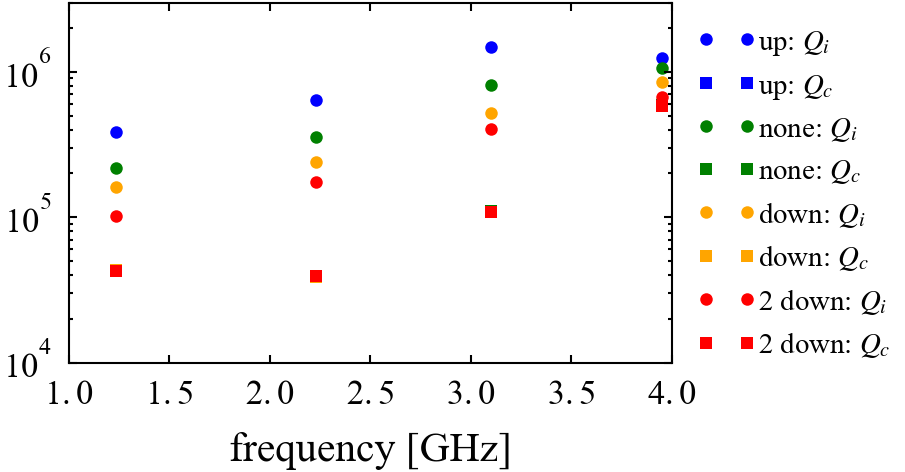

In [43]:
fig, ax = plt.subplots()

ax.plot([1e-9 * r.f_0 for r in rs_mag_up_with_others],
        [r.Q_i for r in rs_mag_up_with_others],
        marker='o', markeredgecolor='none', linestyle='none',
        color=mag_up_color, label='up: $Q_i$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_up_with_others],
        [r.Q_e_real for r in rs_mag_up_with_others],
        marker='s', markeredgecolor='none', linestyle='none',
        color=mag_up_color, label='up: $Q_c$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_none],
        [r.Q_i for r in rs_mag_none],
        marker='o', markeredgecolor='none', linestyle='none',
        color=mag_none_color, label='none: $Q_i$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_none],
        [r.Q_e_real for r in rs_mag_none],
        marker='s', markeredgecolor='none', linestyle='none',
        color=mag_none_color, label='none: $Q_c$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_down],
        [r.Q_i for r in rs_mag_down],
        marker='o', markeredgecolor='none', linestyle='none',
        color=mag_down_color, label='down: $Q_i$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_down],
        [r.Q_e_real for r in rs_mag_down],
        marker='s', markeredgecolor='none', linestyle='none',
        color=mag_down_color, label='down: $Q_c$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_down2],
        [r.Q_i for r in rs_mag_down2],
        marker='o', markeredgecolor='none', linestyle='none',
        color=mag_down2_color, label='2 down: $Q_i$')

ax.plot([1e-9 * r.f_0 for r in rs_mag_down2],
        [r.Q_e_real for r in rs_mag_down2],
        marker='s', markeredgecolor='none', linestyle='none',
        color=mag_down2_color, label='2 down: $Q_c$')

ax.set_yscale('log')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='xx-small')
ax.set_xlabel('frequency [GHz]')
ax.set_ylim(1e4, 3e6);

fig.savefig('/Users/daniel/Desktop/Qs_vs_fr_in_four_magnet_configurations.pdf', bbox_inches='tight')

# Resonator fits: magnet up

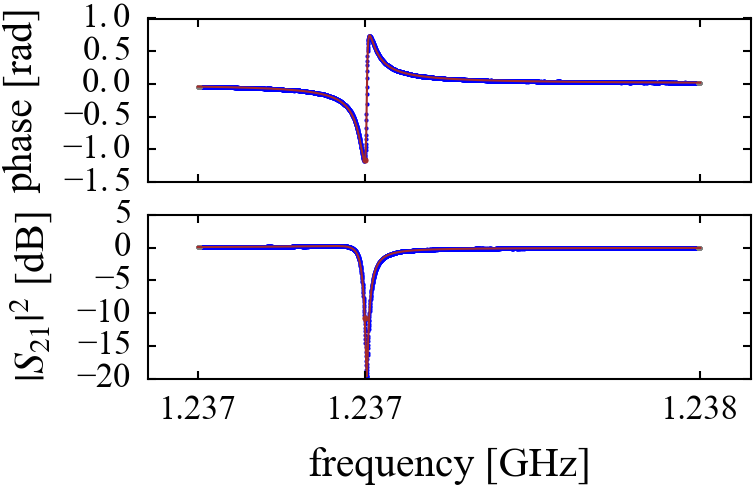

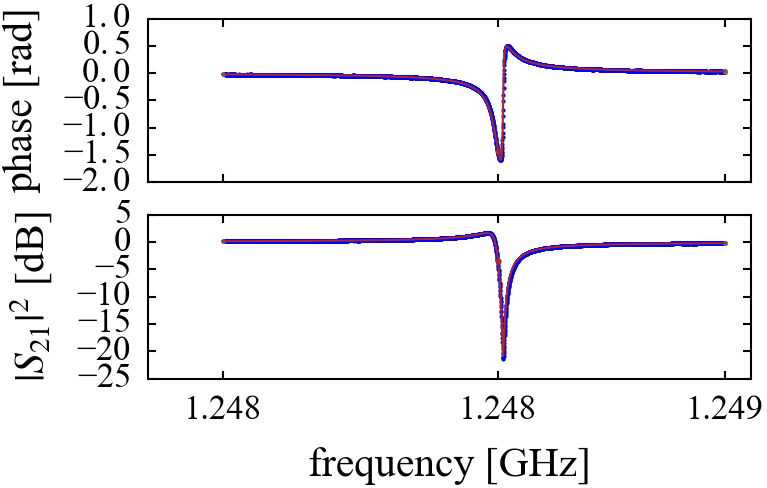

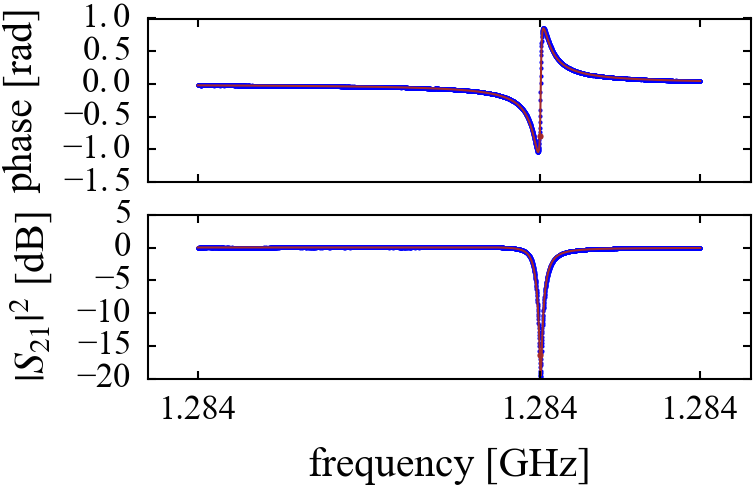

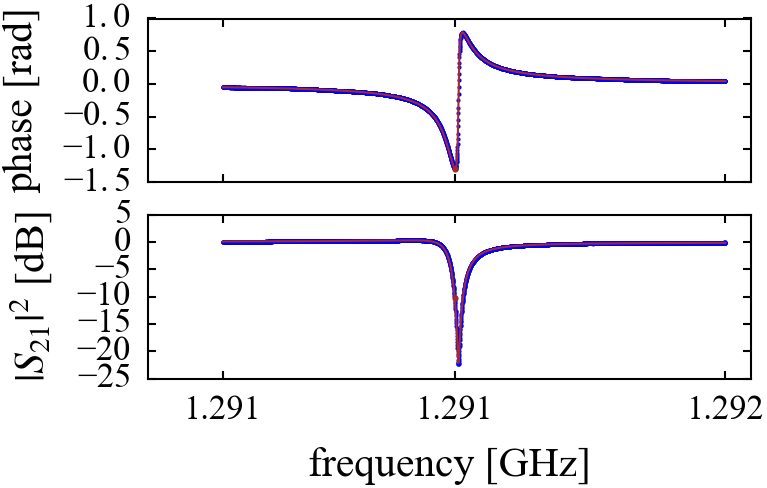

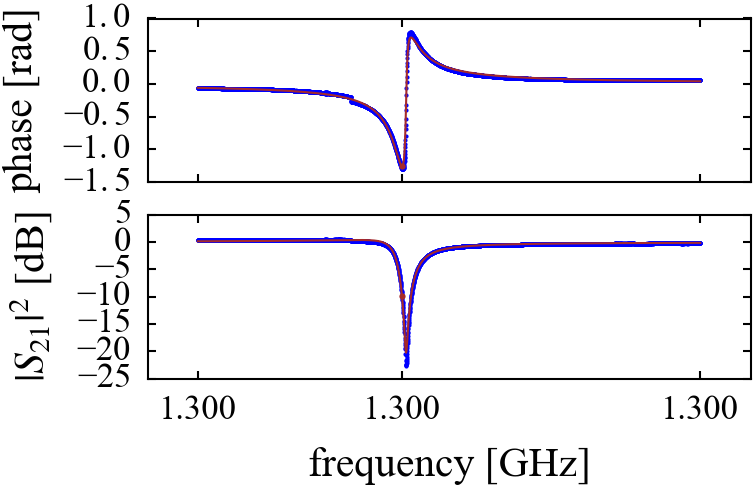

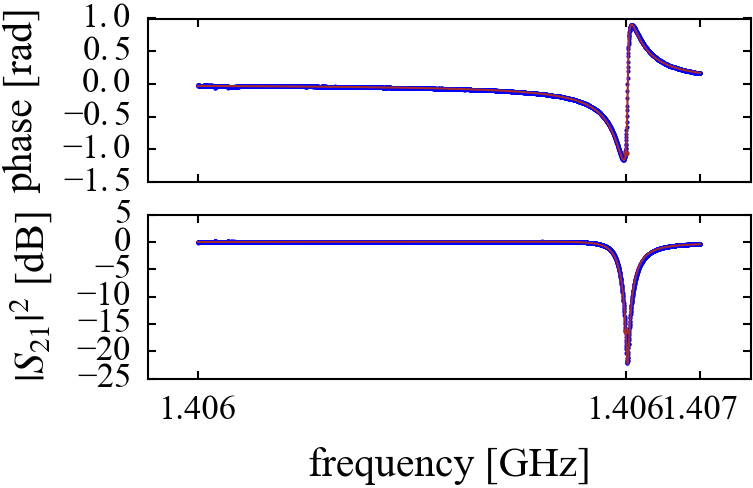

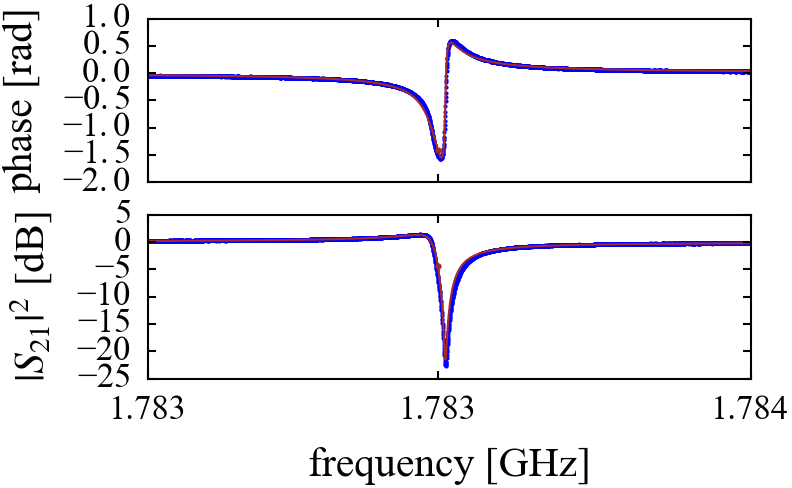

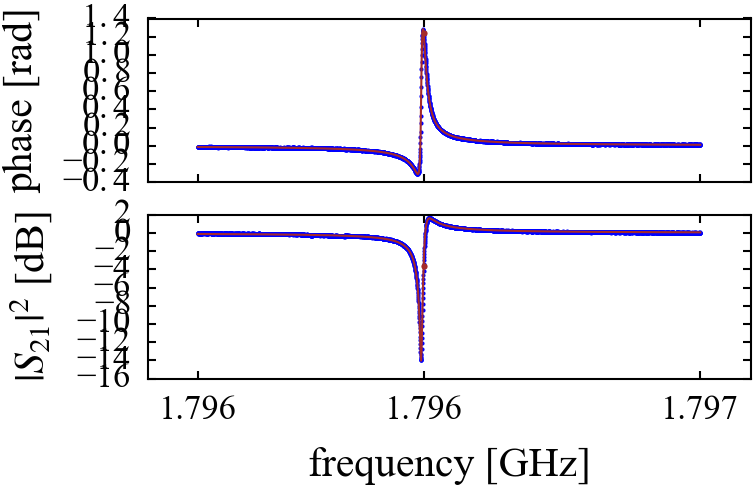

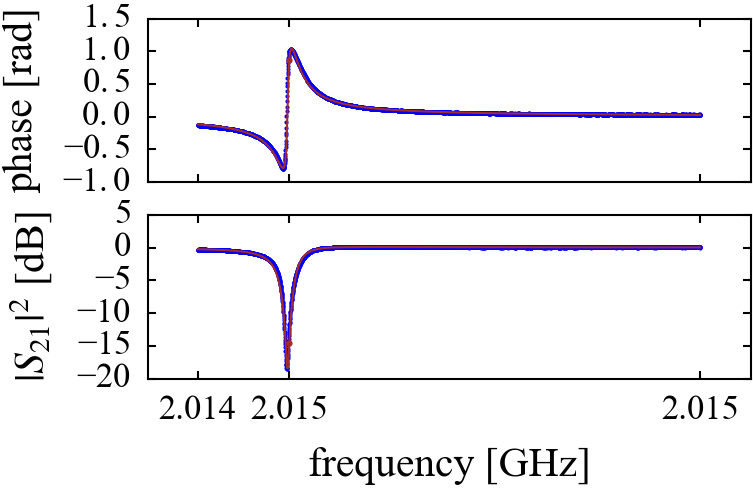

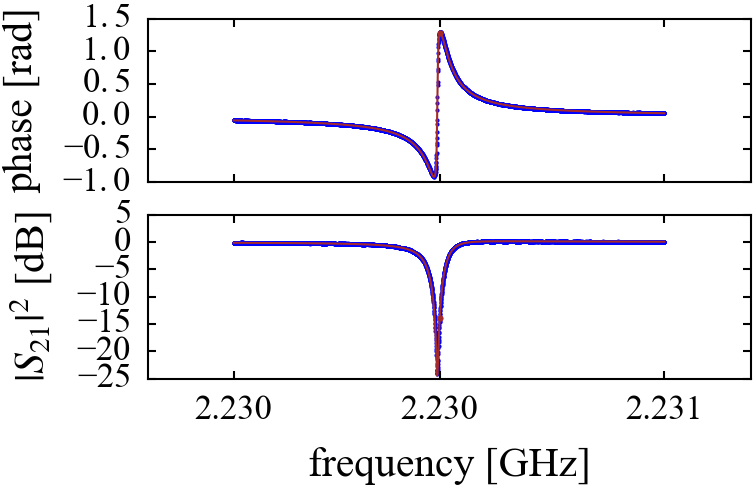

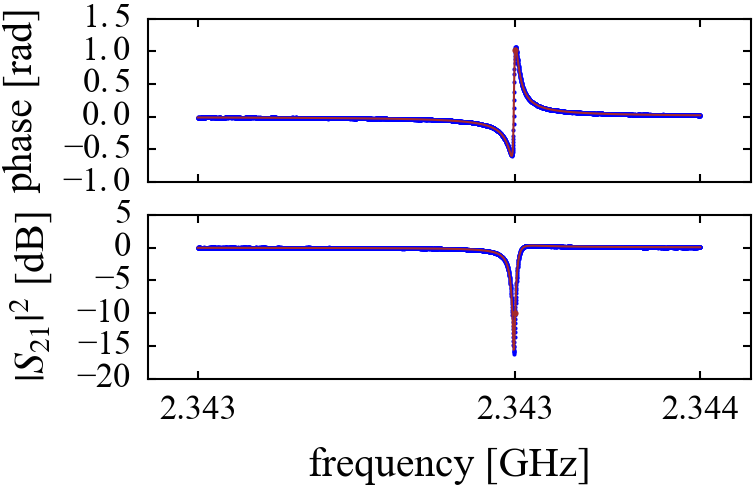

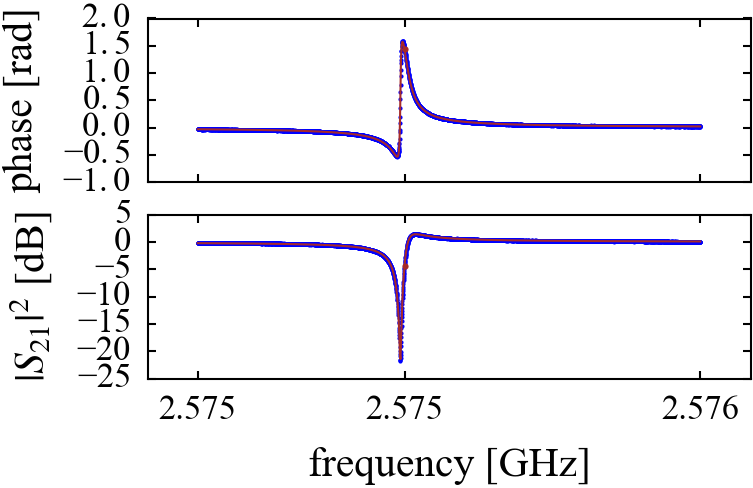

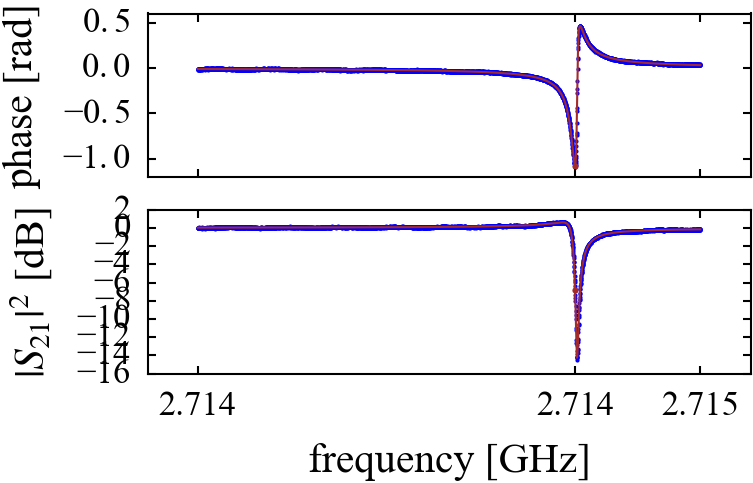

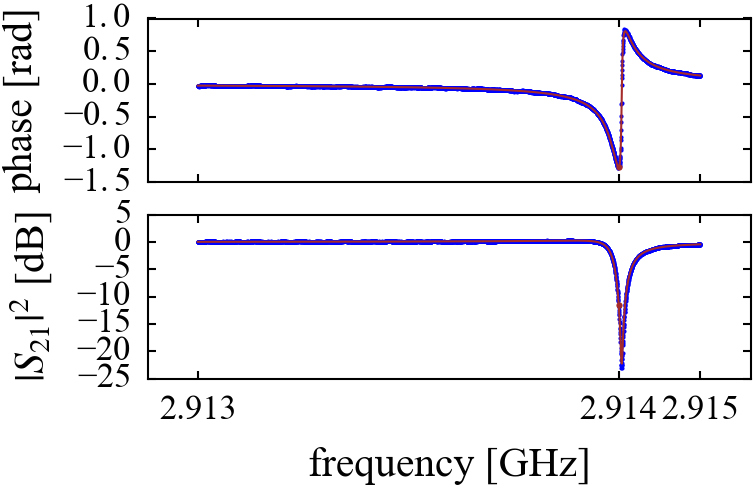

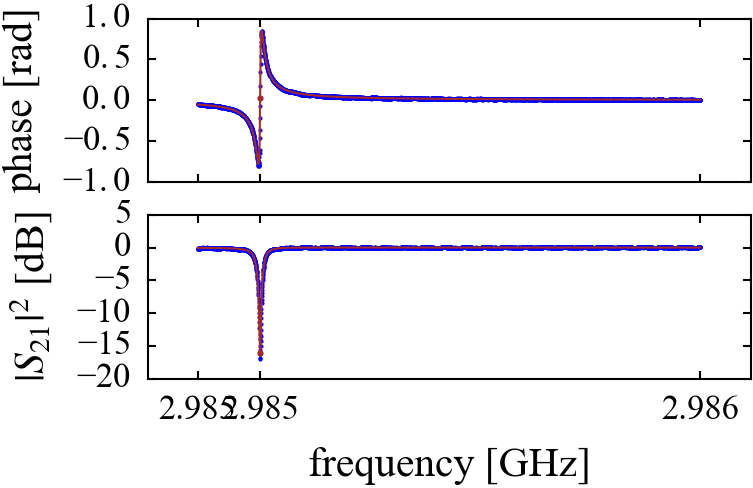

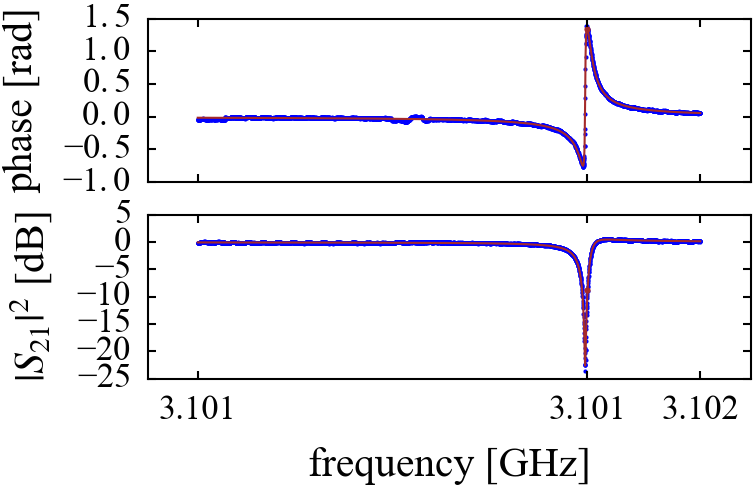

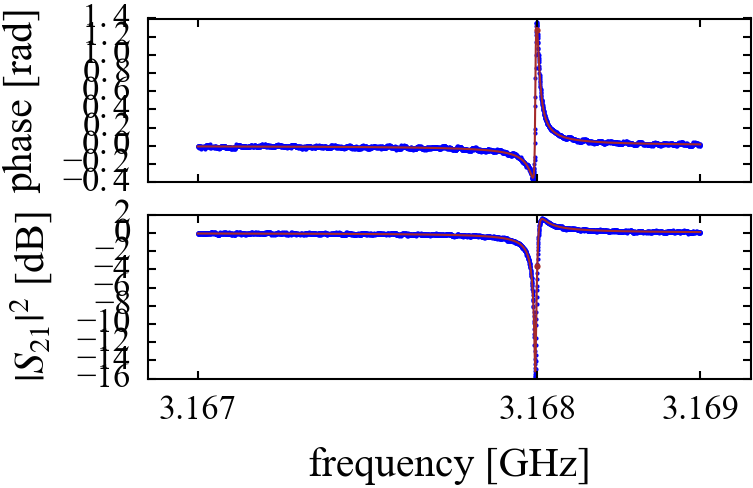

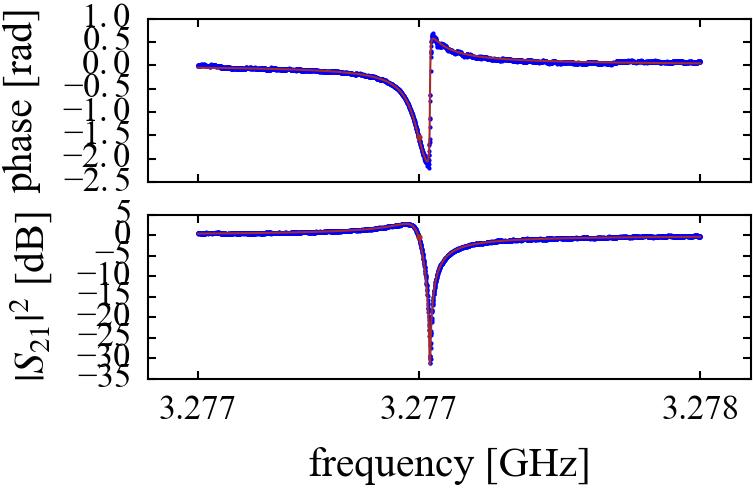

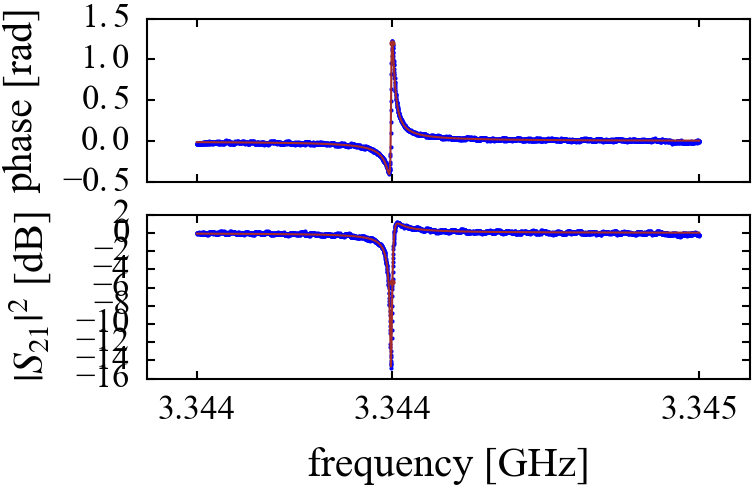

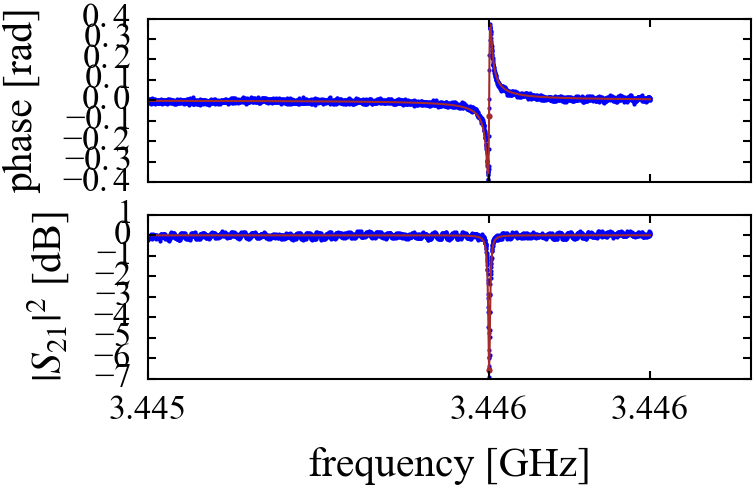

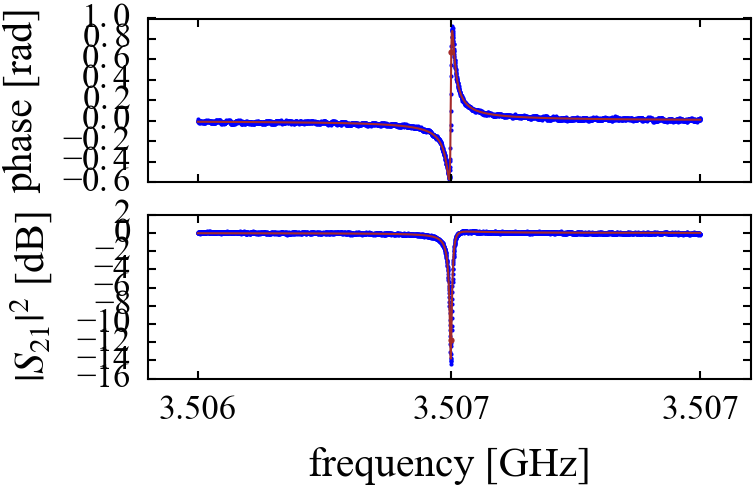

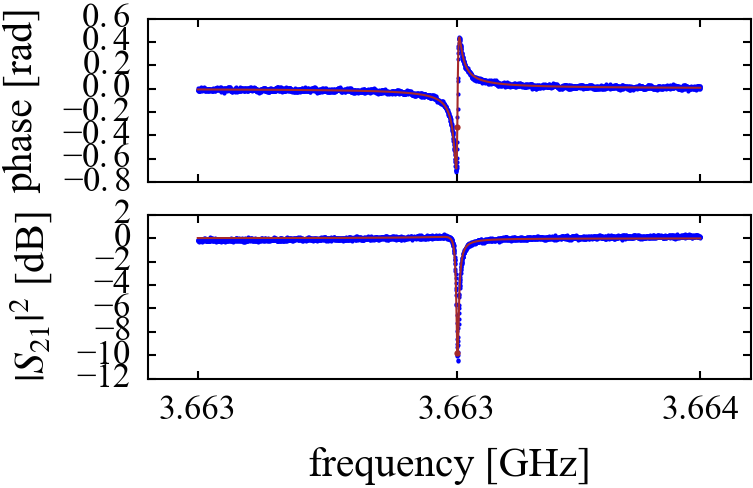

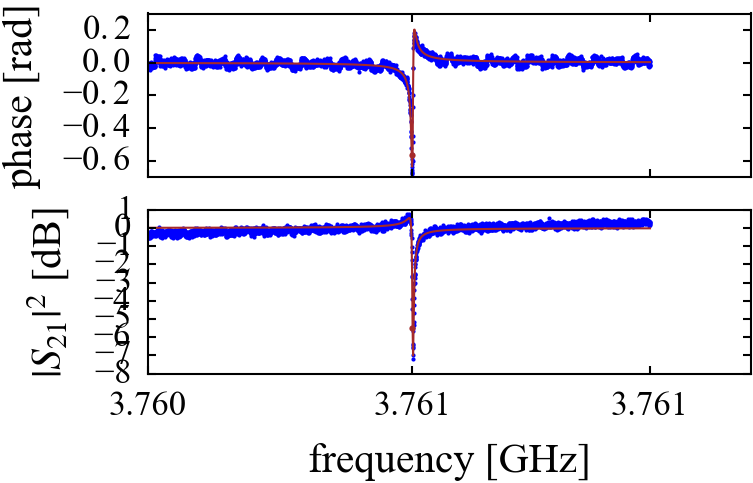

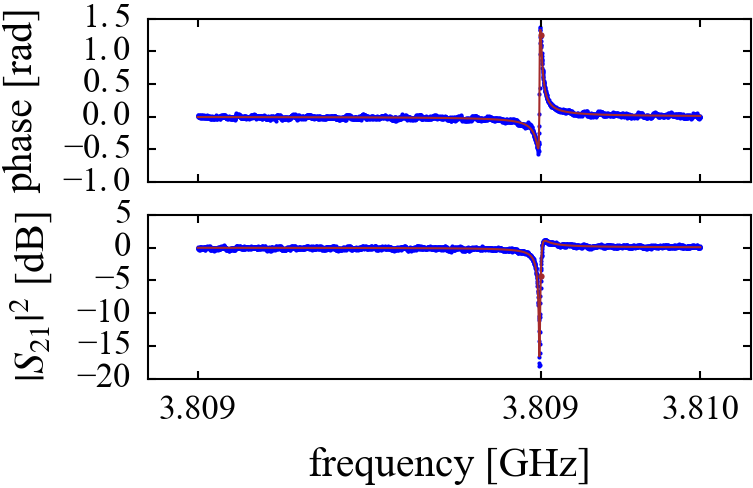

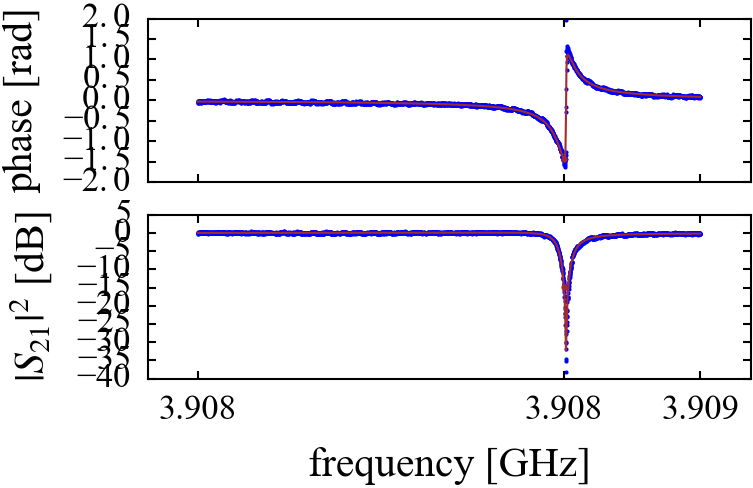

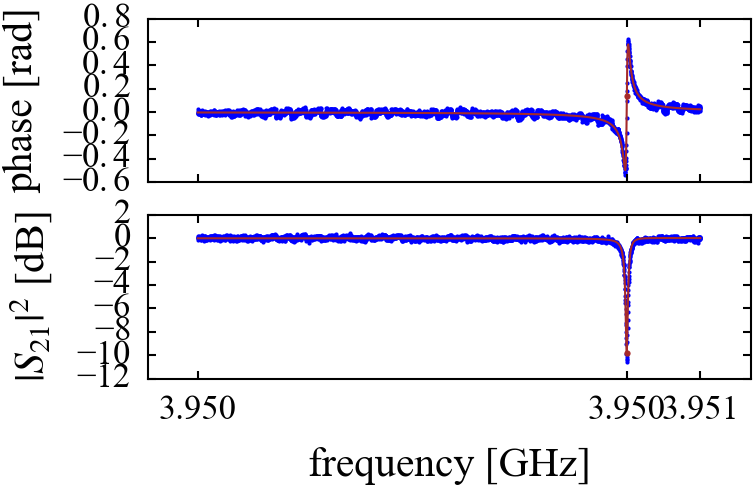

In [11]:
for r in rs_mag_up:
    plot_resonator.amplitude_and_phase(r, normalize_s21=True, freq_scale=1e-9, xlabel='frequency [GHz]')

# Resonator fits: no magnet

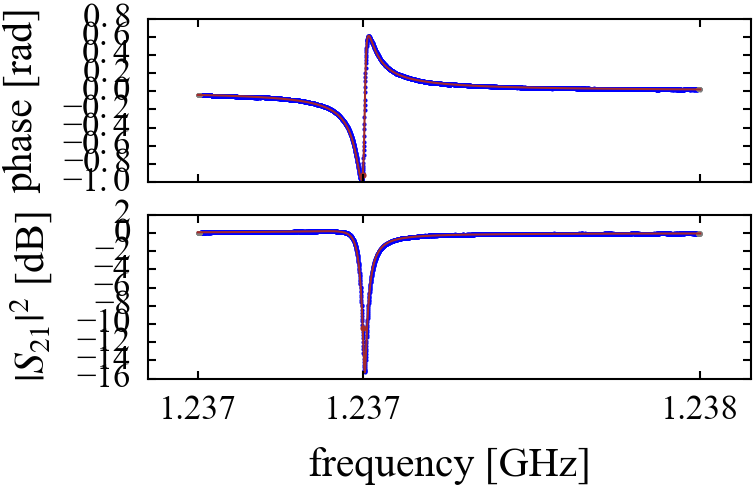

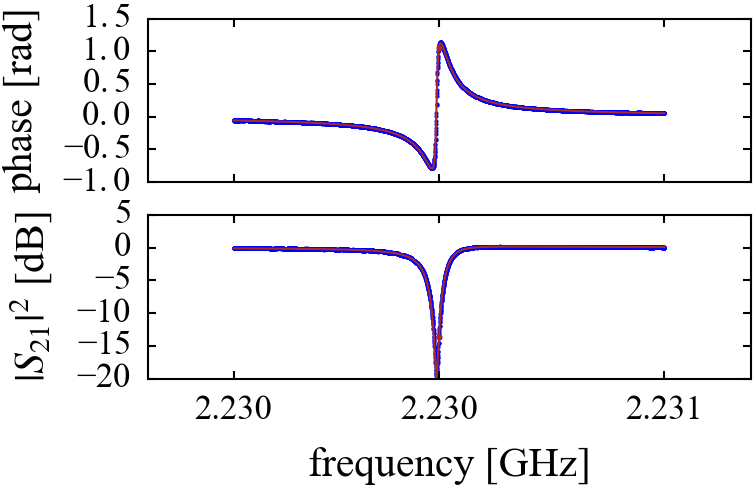

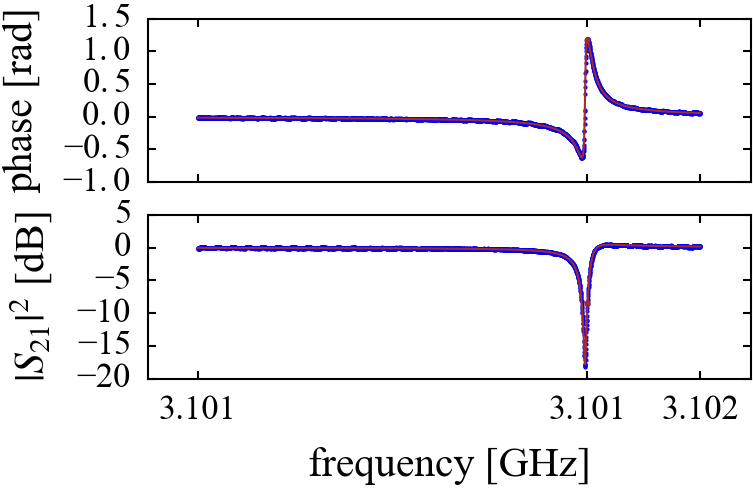

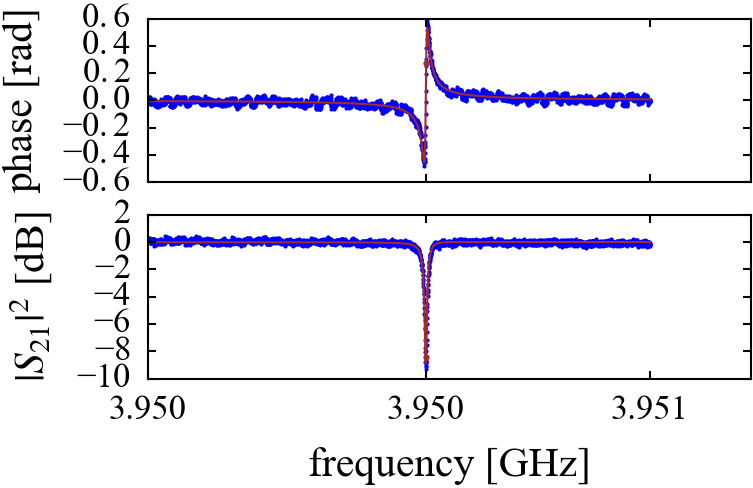

In [12]:
for r in rs_mag_none:
    plot_resonator.amplitude_and_phase(r, normalize_s21=True, freq_scale=1e-9, xlabel='frequency [GHz]')

# Resonator fits: magnet down

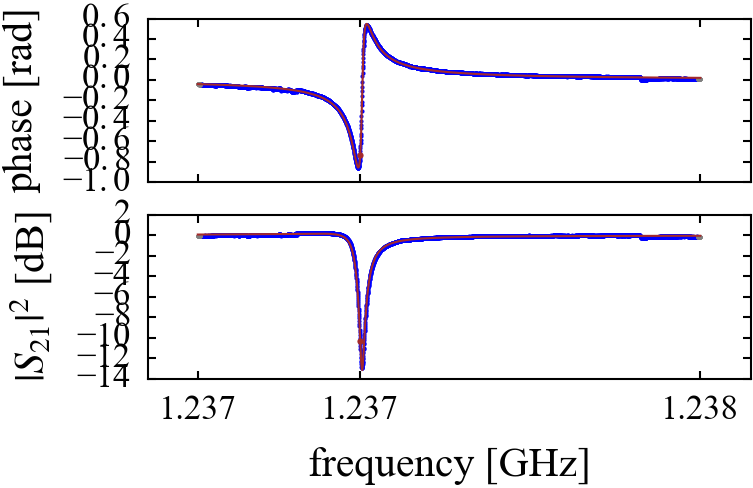

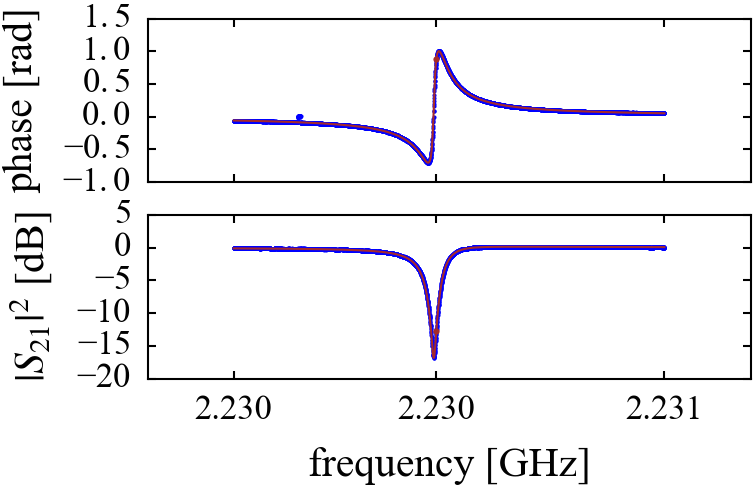

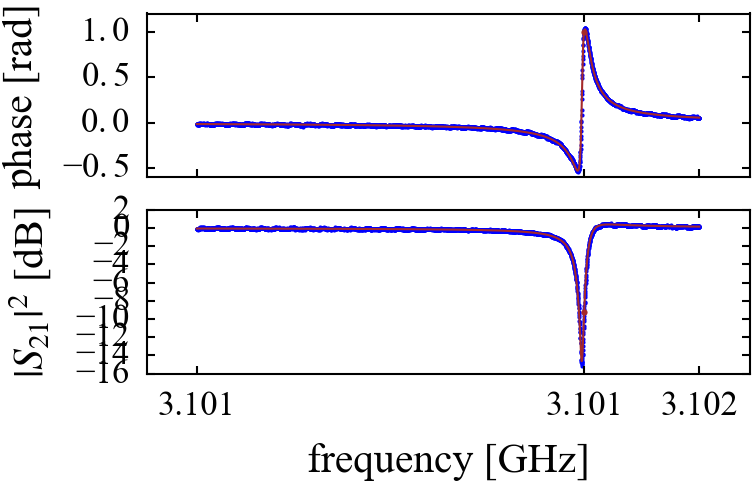

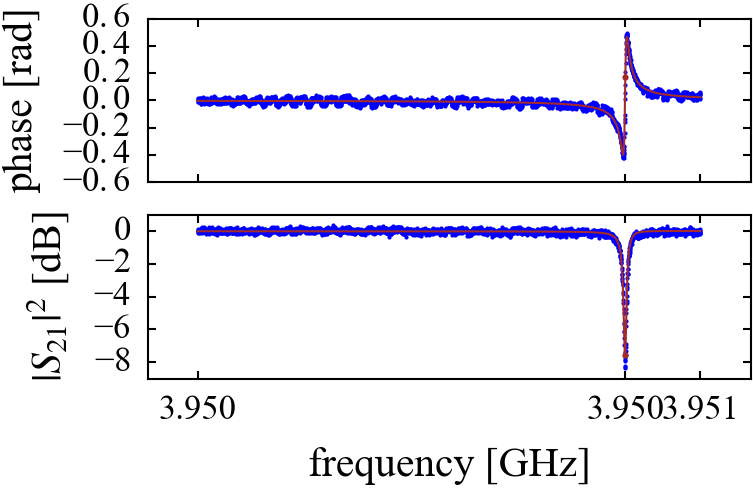

In [13]:
for r in rs_mag_down:
    plot_resonator.amplitude_and_phase(r, normalize_s21=True, freq_scale=1e-9, xlabel='frequency [GHz]')

# Resonator fits: two magnets down

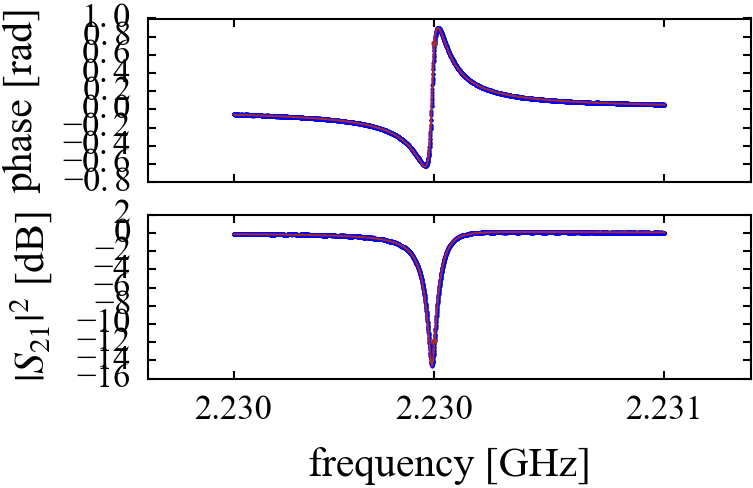

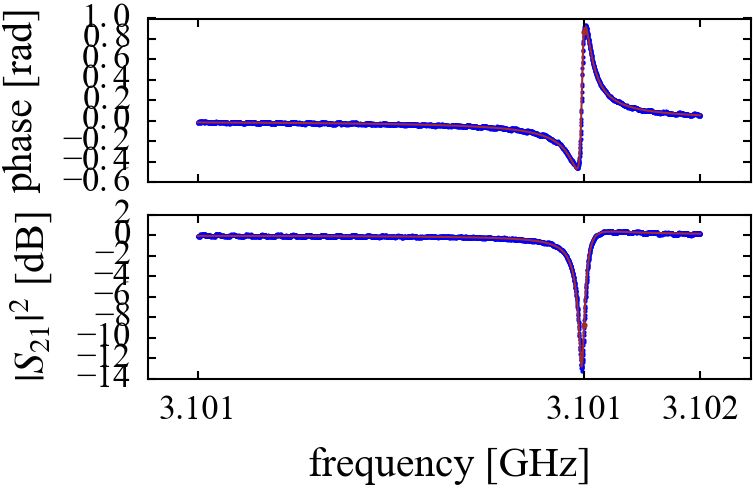

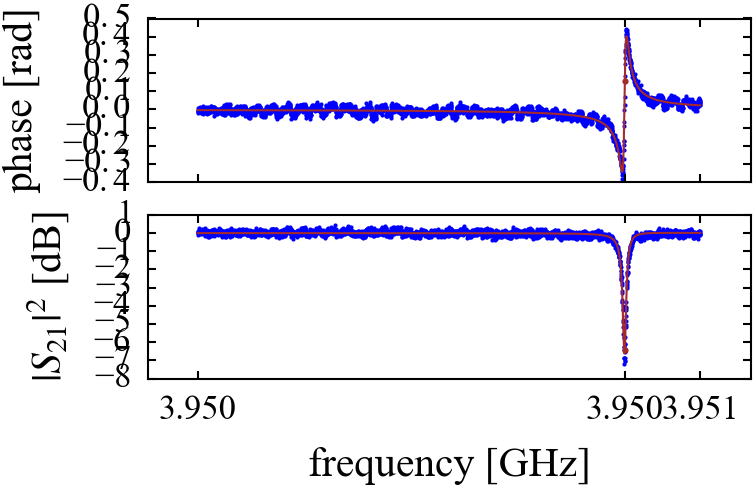

In [14]:
for r in rs_mag_down2:
    plot_resonator.amplitude_and_phase(r, normalize_s21=True, freq_scale=1e-9, xlabel='frequency [GHz]')